# Qwen Image Edit 2509 — Camera Angle Control

This notebook demonstrates how to use **Qwen Image Edit 2509** with the **Camera Control LoRA** for manipulating camera angles in images.

**Components used:**
- **Base Model:** [`Qwen/Qwen-Image-Edit-2509`](https://huggingface.co/Qwen/Qwen-Image-Edit-2509) — Qwen's image editing foundation model
- **Accelerated Transformer:** [`linoyts/Qwen-Image-Edit-Rapid-AIO`](https://huggingface.co/linoyts/Qwen-Image-Edit-Rapid-AIO) — Distilled transformer for fast 4-step inference
- **Camera LoRA:** [`dx8152/Qwen-Edit-2509-Multiple-angles`](https://huggingface.co/dx8152/Qwen-Edit-2509-Multiple-angles) — LoRA fine-tuned for camera movement control

**Reference Space:** [linoyts/Qwen-Image-Edit-Angles](https://huggingface.co/spaces/linoyts/Qwen-Image-Edit-Angles)

## Model Capabilities

### What it does
This model takes an **input image** and a **camera movement prompt**, then generates a new image showing the scene from the requested camera angle/position. It effectively performs **novel view synthesis** guided by natural language.

### Inputs
| Input | Type | Description |
|-------|------|-------------|
| `image` | PIL Image (or list) | The source image to transform |
| `prompt` | String | Bilingual (Chinese + English) camera movement instruction |
| `num_inference_steps` | Int | Number of denoising steps (4 with the Rapid model) |
| `true_cfg_scale` | Float | Classifier-free guidance scale (1.0 = no guidance) |
| `height` / `width` | Int | Output image dimensions (multiples of 8) |
| `seed` | Int | Random seed for reproducibility |

### Outputs
| Output | Type | Description |
|--------|------|-------------|
| `images` | List[PIL Image] | Generated image(s) with the applied camera transformation |

### Supported Camera Movements

| Movement | Prompt (Chinese + English) |
|----------|---------------------------|
| Rotate left N° | `将镜头向左旋转N度 Rotate the camera N degrees to the left.` |
| Rotate right N° | `将镜头向右旋转N度 Rotate the camera N degrees to the right.` |
| Move forward | `将镜头向前移动 Move the camera forward.` |
| Close-up | `将镜头转为特写镜头 Turn the camera to a close-up.` |
| Bird's-eye view | `将相机转向鸟瞰视角 Turn the camera to a bird's-eye view.` |
| Worm's-eye view | `将相机切换到仰视视角 Turn the camera to a worm's-eye view.` |
| Wide-angle lens | `将镜头转为广角镜头 Turn the camera to a wide-angle lens.` |
| Move left | `将镜头向左移动 Move the camera left.` |
| Move right | `将镜头向右移动 Move the camera right.` |
| Move down | `将镜头向下移动 Move the camera down.` |
| Top-down view | `将镜头转为俯视 Turn the camera to a top-down view.` |

> **Note:** Prompts are bilingual (Chinese + English). The model was trained with both languages in the prompt for best results. You can combine multiple movements in a single prompt.

---
## Approach 1: Remote API via Gradio Client (No GPU Required)

The simplest way to use this model is through the hosted Hugging Face Space API. This requires **no GPU** and no large model downloads.

In [ ]:
# Install/upgrade the Gradio client (handle_file requires >= 0.7.0)
!pip install -q --upgrade gradio_client Pillow

In [ ]:
import gradio_client
print(f"gradio_client version: {gradio_client.__version__}")

from gradio_client import Client
try:
    from gradio_client import handle_file
except ImportError:
    handle_file = lambda x: x
    print("WARNING: handle_file not found — your gradio_client is too old.")
    print("Run the install cell above, then **Restart Kernel**, then re-run this cell.")

from PIL import Image
from IPython.display import display
import os
import time

# Connect to the hosted Space (may take a moment if the Space is sleeping)
client = Client("linoyts/Qwen-Image-Edit-Angles")
print("Connected to the Qwen Image Edit Camera Control Space!")

gradio_client version: 2.0.3
Loaded as API: https://linoyts-qwen-image-edit-angles.hf.space
Connected to the Qwen Image Edit Camera Control Space!


In [9]:
def camera_edit_api(
    image_path: str,
    rotate_deg: float = 0.0,
    move_forward: float = 0.0,
    vertical_tilt: float = 0.0,
    wideangle: bool = False,
    seed: int = 0,
    randomize_seed: bool = True,
    true_guidance_scale: float = 1.0,
    num_inference_steps: int = 4,
    height: int = 1024,
    width: int = 1024,
    max_retries: int = 3,
) -> Image.Image:
    """
    Call the Qwen Image Edit Camera Control API with retry logic.

    Parameters:
        image_path: Path to the input image file
        rotate_deg: Camera rotation in degrees (-90 to 90, positive=left)
        move_forward: Forward movement (0=none, 5=forward, 10=close-up)
        vertical_tilt: Vertical tilt (-1=bird's-eye, 0=level, 1=worm's-eye)
        wideangle: Whether to apply wide-angle lens effect
        seed: Random seed for reproducibility
        randomize_seed: If True, uses a random seed
        true_guidance_scale: CFG guidance scale (1.0 = no guidance)
        num_inference_steps: Number of denoising steps (4 recommended)
        height: Output image height (multiple of 8)
        width: Output image width (multiple of 8)
        max_retries: Number of retries if Space errors (ZeroGPU can be flaky)

    Returns:
        PIL.Image.Image: The camera-transformed output image
    """
    for attempt in range(1, max_retries + 1):
        try:
            result = client.predict(
                image=handle_file(image_path),
                rotate_deg=rotate_deg,
                move_forward=move_forward,
                vertical_tilt=vertical_tilt,
                wideangle=wideangle,
                seed=seed,
                randomize_seed=randomize_seed,
                true_guidance_scale=true_guidance_scale,
                num_inference_steps=num_inference_steps,
                height=height,
                width=width,
                api_name="/infer_edit_camera_angles",
            )
            # result is a tuple: (output_image_path, seed, prompt_text)
            output_image = Image.open(result[0])
            print(f"Generated prompt: {result[2]}")
            print(f"Seed used: {result[1]}")
            return output_image
        except Exception as e:
            print(f"Attempt {attempt}/{max_retries} failed: {e}")
            if attempt < max_retries:
                wait = 10 * attempt
                print(f"Retrying in {wait}s (Space may be waking up or allocating GPU)...")
                time.sleep(wait)
            else:
                raise RuntimeError(
                    f"Failed after {max_retries} attempts. The Space may be down or overloaded.\n"
                    f"Try again later, or visit https://huggingface.co/spaces/linoyts/Qwen-Image-Edit-Angles "
                    f"to check if the Space is running.\nLast error: {e}"
                )

Input image size: (1280, 1024)


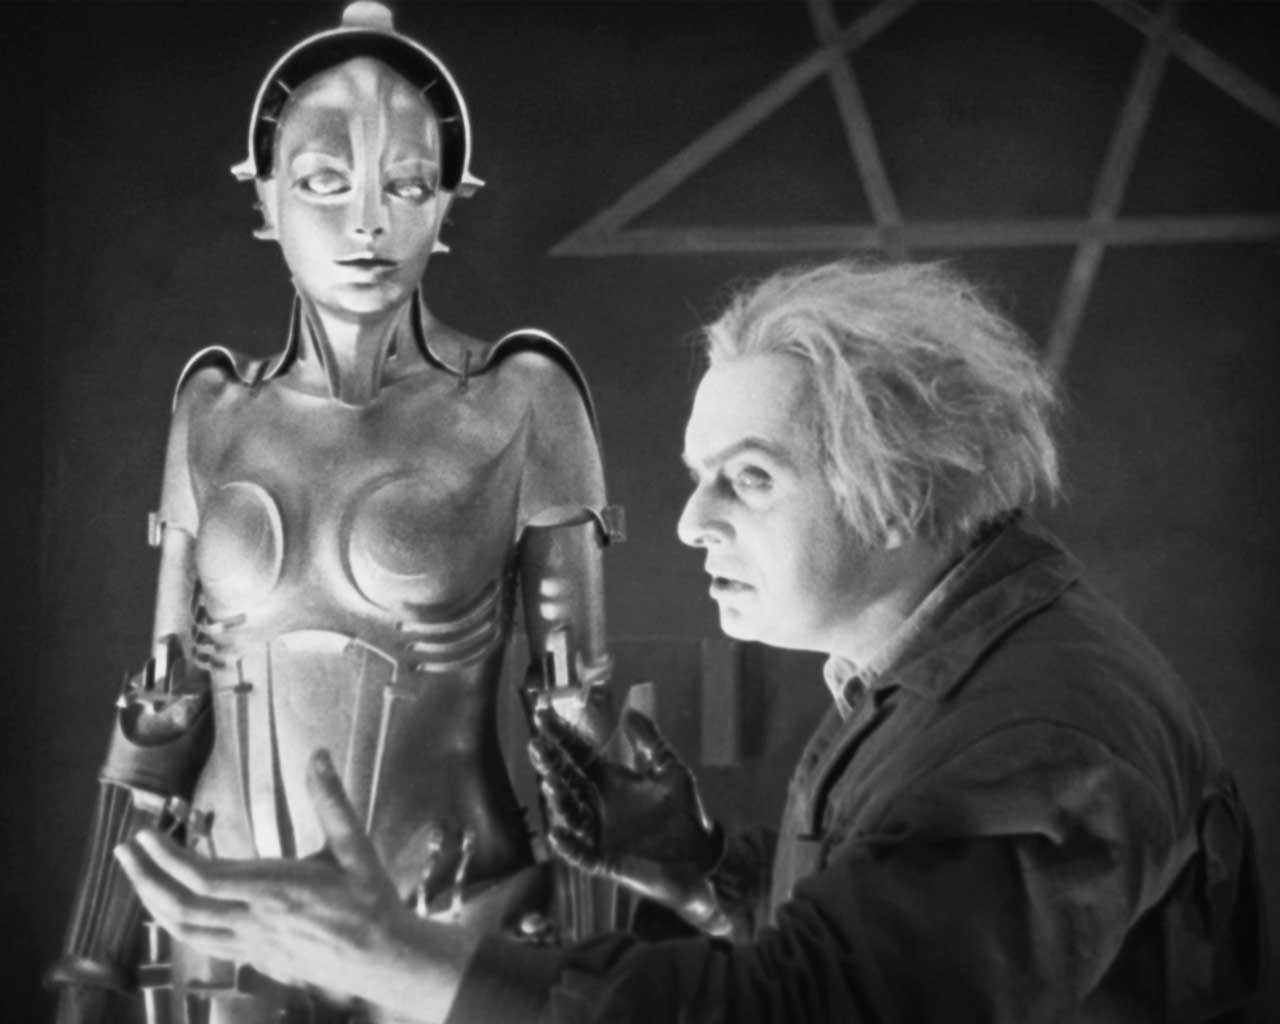

In [10]:
# Download a sample image to test with
import urllib.request

sample_url = "https://huggingface.co/spaces/linoyts/Qwen-Image-Edit-Angles/resolve/main/metropolis.jpg"
sample_path = "sample_input.jpg"

if not os.path.exists(sample_path):
    urllib.request.urlretrieve(sample_url, sample_path)
    print(f"Downloaded sample image to {sample_path}")

input_image = Image.open(sample_path)
print(f"Input image size: {input_image.size}")
display(input_image)

In [11]:
# Example 1: Rotate camera 90 degrees to the left
print("=== Rotate 90° Left ===")
result_left = camera_edit_api(sample_path, rotate_deg=90)
display(result_left)

=== Rotate 90° Left ===
Attempt 1/3 failed: Error
Retrying in 10s (Space may be waking up or allocating GPU)...
Attempt 2/3 failed: Error
Retrying in 20s (Space may be waking up or allocating GPU)...
Attempt 3/3 failed: Error


RuntimeError: Failed after 3 attempts. The Space may be down or overloaded.
Try again later, or visit https://huggingface.co/spaces/linoyts/Qwen-Image-Edit-Angles to check if the Space is running.
Last error: Error

In [ ]:
# Example 2: Bird's-eye view (looking down from above)
print("=== Bird's-Eye View ===")
result_birds_eye = camera_edit_api(sample_path, vertical_tilt=-1)
display(result_birds_eye)

In [ ]:
# Example 3: Worm's-eye view + rotate 45 degrees right
print("=== Worm's-Eye View + Rotate 45° Right ===")
result_combo = camera_edit_api(sample_path, rotate_deg=-45, vertical_tilt=1)
display(result_combo)

In [ ]:
# Example 4: Close-up shot
print("=== Close-Up Shot ===")
result_closeup = camera_edit_api(sample_path, move_forward=10)
display(result_closeup)

---
## Approach 2: Local Inference (Requires GPU with ~24GB+ VRAM)

For full local inference, you'll need a GPU with sufficient VRAM (A100 40GB+ recommended). This approach gives you full control over the model and avoids API rate limits.

In [1]:
# Install dependencies for local inference
# transformers >= 4.46 required for Qwen2_5_VLForConditionalGeneration
!pip install -q git+https://github.com/huggingface/diffusers.git
!pip install -q --upgrade transformers accelerate safetensors sentencepiece peft Pillow

In [2]:
import torch
import random
import numpy as np
from PIL import Image
from IPython.display import display

from diffusers import QwenImageEditPlusPipeline, QwenImageTransformer2DModel

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_mem / 1e9:.1f} GB")

/jet/home/aanugu/.conda/envs/cdviews/lib/python3.10/site-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/jet/home/aanugu/.conda/envs/cdviews/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

===================================BUG REPORT===================================
The following directories listed in your path were found to be non-existent: {PosixPath('1;/jet/home/aanugu/.cursor-server/bin/linux-x64/3578107fdf149b00059ddad37048220e41681000/bin/remote-cli'), PosixPath('1;/jet/home/aanugu/.local/bin'), PosixPath('1;/opt/packages/anaconda3-2024.10-1/condabin'), PosixPath('1;/usr/local/sbin'), PosixPath('2;/opt/packages/anaconda3-2024.10-1/bin'), PosixPath('1'), PosixPath('1;/usr/bin'), PosixPath('1;/opt/puppetlabs/bin'), PosixPath('1;/usr/sbin'), PosixPath('1;/opt/packages/allocations/bin'), PosixPath('2;/jet/home/aanugu/bin'), PosixPath('1;/opt/packages/interact/bin'), PosixPath('1;/usr/local/bin')}
The following directories listed in your path were found to be non-existent: {PosixPath('1;/opt/modulefiles/production/psc.allocations.user/1.0.lua'), PosixPath('1')}
The following directories listed in your path were found to be non-existent: {PosixPath('1;/opt/modu

/jet/home/aanugu/.conda/envs/cdviews/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
/jet/home/aanugu/.conda/envs/cdviews/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /opt/packages/anaconda3-2024.10-1 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/jet/home/aanugu/.conda/envs/cdviews/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!                     If you run into issues with 8-bit matmul, you can try 4-bit quantization: https://huggingface.co/blog/4bit-transformers-bitsandbytes
  warn(msg)


RuntimeError: Failed to import diffusers.pipelines.qwenimage.pipeline_qwenimage_edit_plus because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.lora_pipeline because of the following error (look up to see its traceback):

        CUDA Setup failed despite GPU being available. Please run the following command to get more information:

        python -m bitsandbytes

        Inspect the output of the command and see if you can locate CUDA libraries. You might need to add them
        to your LD_LIBRARY_PATH. If you suspect a bug, please take the information from python -m bitsandbytes
        and open an issue at: https://github.com/TimDettmers/bitsandbytes/issues

In [ ]:
# Load the pipeline with the accelerated transformer
# The Rapid-AIO transformer enables 4-step inference (vs 50 steps for the base model)
print("Loading pipeline... (this may take a few minutes on first run)")

pipe = QwenImageEditPlusPipeline.from_pretrained(
    "Qwen/Qwen-Image-Edit-2509",
    transformer=QwenImageTransformer2DModel.from_pretrained(
        "linoyts/Qwen-Image-Edit-Rapid-AIO",
        subfolder="transformer",
        torch_dtype=dtype,
    ),
    torch_dtype=dtype,
).to(device)

print("Base pipeline loaded!")

In [ ]:
# Load the camera control LoRA
print("Loading camera control LoRA...")

pipe.load_lora_weights(
    "dx8152/Qwen-Edit-2509-Multiple-angles",
    weight_name="\u955c\u5934\u8f6c\u6362.safetensors",  # 镜头转换.safetensors
    adapter_name="angles",
)

# Activate and fuse the LoRA for faster inference
pipe.set_adapters(["angles"], adapter_weights=[1.0])
pipe.fuse_lora(adapter_names=["angles"], lora_scale=1.25)
pipe.unload_lora_weights()  # Free memory after fusing

print("Camera control LoRA loaded and fused!")

In [ ]:
def build_camera_prompt(
    rotate_deg: float = 0.0,
    move_forward: float = 0.0,
    vertical_tilt: float = 0.0,
    wideangle: bool = False,
) -> str:
    """
    Build a bilingual camera movement prompt.

    Args:
        rotate_deg: Rotation in degrees. Positive = left, negative = right.
                    Typical values: -90, -45, 0, 45, 90
        move_forward: Forward movement. 0 = none, 1-5 = move forward, >5 = close-up.
                      Typical values: 0, 5, 10
        vertical_tilt: Vertical tilt. -1 = bird's-eye, 0 = level, 1 = worm's-eye.
                       Typical values: -1, 0, 1
        wideangle: If True, applies wide-angle lens effect.

    Returns:
        Bilingual prompt string (Chinese + English)
    """
    parts = []

    if rotate_deg != 0:
        direction = "left" if rotate_deg > 0 else "right"
        cn_dir = "左" if rotate_deg > 0 else "右"
        parts.append(
            f"将镜头向{cn_dir}旋转{abs(rotate_deg)}度 "
            f"Rotate the camera {abs(rotate_deg)} degrees to the {direction}."
        )

    if move_forward > 5:
        parts.append("将镜头转为特写镜头 Turn the camera to a close-up.")
    elif move_forward >= 1:
        parts.append("将镜头向前移动 Move the camera forward.")

    if vertical_tilt <= -1:
        parts.append("将相机转向鸟瞰视角 Turn the camera to a bird's-eye view.")
    elif vertical_tilt >= 1:
        parts.append("将相机切换到仰视视角 Turn the camera to a worm's-eye view.")

    if wideangle:
        parts.append("将镜头转为广角镜头 Turn the camera to a wide-angle lens.")

    return " ".join(parts).strip() if parts else "no camera movement"


# Test the prompt builder
print(build_camera_prompt(rotate_deg=45))
print(build_camera_prompt(vertical_tilt=-1))
print(build_camera_prompt(rotate_deg=-90, vertical_tilt=1))

In [ ]:
def camera_edit(
    image: Image.Image,
    rotate_deg: float = 0.0,
    move_forward: float = 0.0,
    vertical_tilt: float = 0.0,
    wideangle: bool = False,
    seed: int = 0,
    randomize_seed: bool = True,
    true_cfg_scale: float = 1.0,
    num_inference_steps: int = 4,
    height: int = None,
    width: int = None,
) -> tuple:
    """
    Apply a camera angle transformation to an image.

    Args:
        image: Input PIL Image
        rotate_deg: Rotation degrees (-90 to 90, positive=left)
        move_forward: Forward movement (0, 5, or 10)
        vertical_tilt: Vertical tilt (-1, 0, or 1)
        wideangle: Wide-angle lens effect
        seed: Random seed
        randomize_seed: Use random seed if True
        true_cfg_scale: Guidance scale
        num_inference_steps: Denoising steps (4 for Rapid model)
        height: Output height (auto-computed if None)
        width: Output width (auto-computed if None)

    Returns:
        Tuple of (output_image, seed_used, prompt)
    """
    prompt = build_camera_prompt(rotate_deg, move_forward, vertical_tilt, wideangle)
    print(f"Prompt: {prompt}")

    if prompt == "no camera movement":
        return image, seed, prompt

    # Auto-compute output dimensions preserving aspect ratio
    if height is None or width is None:
        orig_w, orig_h = image.size
        if orig_w > orig_h:
            width = 1024
            height = int(1024 * orig_h / orig_w)
        else:
            height = 1024
            width = int(1024 * orig_w / orig_h)
        width = (width // 8) * 8
        height = (height // 8) * 8

    if randomize_seed:
        seed = random.randint(0, np.iinfo(np.int32).max)
    generator = torch.Generator(device=device).manual_seed(seed)

    result = pipe(
        image=[image.convert("RGB")],
        prompt=prompt,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        generator=generator,
        true_cfg_scale=true_cfg_scale,
        num_images_per_prompt=1,
    ).images[0]

    print(f"Seed: {seed} | Output size: {result.size}")
    return result, seed, prompt

In [ ]:
# Load a sample image
import urllib.request
import os

sample_url = "https://huggingface.co/spaces/linoyts/Qwen-Image-Edit-Angles/resolve/main/metropolis.jpg"
sample_path = "sample_input.jpg"

if not os.path.exists(sample_path):
    urllib.request.urlretrieve(sample_url, sample_path)

input_image = Image.open(sample_path).convert("RGB")
print(f"Input image size: {input_image.size}")
display(input_image)

In [ ]:
# Example 1: Rotate camera 90 degrees to the left
print("=== Rotate 90° Left ===")
result_left, seed_left, _ = camera_edit(input_image, rotate_deg=90)
display(result_left)

In [ ]:
# Example 2: Rotate camera 90 degrees to the right
print("=== Rotate 90° Right ===")
result_right, seed_right, _ = camera_edit(input_image, rotate_deg=-90)
display(result_right)

In [ ]:
# Example 3: Bird's-eye view (looking down from above)
print("=== Bird's-Eye View ===")
result_birds, seed_birds, _ = camera_edit(input_image, vertical_tilt=-1)
display(result_birds)

In [ ]:
# Example 4: Worm's-eye view (looking up from below)
print("=== Worm's-Eye View ===")
result_worms, seed_worms, _ = camera_edit(input_image, vertical_tilt=1)
display(result_worms)

In [ ]:
# Example 5: Close-up shot
print("=== Close-Up Shot ===")
result_closeup, seed_closeup, _ = camera_edit(input_image, move_forward=10)
display(result_closeup)

In [ ]:
# Example 6: Combined movement — rotate 45° right + worm's-eye view
print("=== Rotate 45° Right + Worm's-Eye View ===")
result_combo, seed_combo, _ = camera_edit(
    input_image, rotate_deg=-45, vertical_tilt=1
)
display(result_combo)

In [ ]:
# Example 7: Wide-angle lens
print("=== Wide-Angle Lens ===")
result_wide, seed_wide, _ = camera_edit(input_image, wideangle=True)
display(result_wide)

In [ ]:
# Example 8: Sequential camera movements (orbit around subject)
# Apply multiple rotations to the same image to simulate an orbit
print("=== Sequential Orbit: -90° → -45° → 0° → 45° → 90° ===")

angles = [-90, -45, 0, 45, 90]
orbit_results = []

for angle in angles:
    if angle == 0:
        orbit_results.append(input_image)
        continue
    result_img, _, _ = camera_edit(
        input_image, rotate_deg=angle, randomize_seed=False, seed=42
    )
    orbit_results.append(result_img)

# Display all orbit views side by side
for angle, img in zip(angles, orbit_results):
    print(f"\n--- {angle}° ---")
    display(img)

---
## Using Your Own Images

Replace the sample image path with your own image to apply camera transformations.

In [ ]:
# Uncomment and modify to use your own image:

# my_image = Image.open("/path/to/your/image.jpg").convert("RGB")
# result, seed, prompt = camera_edit(
#     my_image,
#     rotate_deg=45,        # Rotate 45° left
#     move_forward=0,       # No forward movement
#     vertical_tilt=0,      # Level camera
#     wideangle=False,      # No wide-angle
#     num_inference_steps=4, # 4 steps for Rapid model
#     true_cfg_scale=1.0,   # No classifier-free guidance
# )
# display(result)
# result.save("my_output.png")

## Tips and Notes

1. **Bilingual prompts**: The LoRA was trained with Chinese + English prompts. Always use both for best results.
2. **4-step inference**: The Rapid-AIO transformer is distilled for fast inference. Using 4 steps gives good results; more steps may not improve quality.
3. **LoRA scale 1.25**: The Space uses `lora_scale=1.25` when fusing, which slightly amplifies the camera control effect.
4. **Combining movements**: You can combine rotation + tilt + zoom + wide-angle in a single prompt for complex camera moves.
5. **Resolution**: Output dimensions should be multiples of 8. The model works best around 1024px on the longer side.
6. **Memory**: The full model requires ~20-24GB VRAM in bfloat16. Use the API approach if GPU memory is limited.
7. **Consistency**: For iterative camera movements on the same scene, use a fixed seed for more consistent results.